## Capstone1
### Analysis of free and paid apps ratings from Google Play Store
Data from April 2019

The null hypothesis Ho: there is no significant difference in rating between paid and free apps in Google Play Store. The alternative hypothesis Ha: there is a significant difference in rating for paid and free apps. 


In [87]:
!pip install hvplot;

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import hvplot.pandas

In [22]:
data_path='https://drive.google.com/uc?export=download&id=1MmuzYdcyjPWWsQcYoMddSkkSqfFFQX55'
#df = pd.read_csv('Google-Playstore-Full.csv') #if reading data from local file 
df = pd.read_csv(data_path)


In [13]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267052 entries, 0 to 267051
Data columns (total 15 columns):
App Name           267051 non-null object
Category           267051 non-null object
Rating             267052 non-null object
Reviews            267051 non-null object
Installs           267052 non-null object
Size               267052 non-null object
Price              267052 non-null object
Content Rating     267052 non-null object
Last Updated       267052 non-null object
Minimum Version    267051 non-null object
Latest Version     267049 non-null object
Unnamed: 11        18 non-null object
Unnamed: 12        3 non-null object
Unnamed: 13        2 non-null object
Unnamed: 14        1 non-null float64
dtypes: float64(1), object(14)
memory usage: 30.6+ MB


,App Name,Category,Rating,Reviews,Installs,Size,Price,Content Rating,Last Updated,Minimum Version,Latest Version,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,DoorDash - Food Delivery,FOOD_AND_DRINK,4.548561573,305034,"5,000,000+",Varies with device,0,Everyone,"March 29, 2019",Varies with device,Varies with device,NaN,NaN,NaN,NaN
1,TripAdvisor Hotels Flights Restaurants Attract...,TRAVEL_AND_LOCAL,4.400671482,1.20792e+06,"100,000,000+",Varies with device,0,Everyone,"March 29, 2019",Varies with device,Varies with device,NaN,NaN,NaN,NaN
2,Peapod,SHOPPING,3.656329393,1967,"100,000+",1.4M,0,Everyone,"September 20, 2018",5.0 and up,2.2.0,NaN,NaN,NaN,NaN
3,foodpanda - Local Food Delivery,FOOD_AND_DRINK,4.107232571,389154,"10,000,000+",16M,0,Everyone,"March 22, 2019",4.2 and up,4.18.2,NaN,NaN,NaN,NaN
4,My CookBook Pro (Ad Free),FOOD_AND_DRINK,4.647752285,2291,"10,000+",Varies with device,$5.99,Everyone,"April 1, 2019",Varies with device,Varies with device,NaN,NaN,NaN,NaN


### Data cleaning
The dataset contains 267051 rows and 15 columns. After closer examination we can see that some columns (Ranking, Reviews) have numeric type, but Pandas loaded them as object (string) type. It happened because some  records are corrupted, and have string values instead of numeric in corresponding columns. Also dataset has four unnamed columns, which don't have any meaningful data, and can be removed.  Before starting working with this dataset, it show be cleaned. 

In [23]:
# dataset cleaning

# Selecting only rows in 'Rating' column which have only numeric values,
# and converting them into numeric values. Non- numeric rows are skipped
df = df[df['Rating'].astype(str).str.replace('.','').str.isnumeric()]
df['Rating'] = pd.to_numeric(df['Rating'])
df['Reviews'] = pd.to_numeric(df['Reviews'])

# 'Price' column contain price in dollars '$' fo paid apps
#  '$' should be remmoved before it converted to numeric type
df['Price']= df['Price'].apply(lambda x: float(x.replace('$',''))   )  
df['Installs']=df['Installs'].apply(lambda y: y.replace(',','').replace('+','')) 
df = df[df['Installs'].astype(str).str.isnumeric()]
df['Installs'] = pd.to_numeric(df['Installs'])

In [26]:
#removing all unnamed columns
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [27]:
df.head(2)

,App Name,Category,Rating,Reviews,Installs,Size,Price,Content Rating,Last Updated,Minimum Version,Latest Version
0,DoorDash - Food Delivery,FOOD_AND_DRINK,4.548562,305034.0,5000000,Varies with device,0.0,Everyone,"March 29, 2019",Varies with device,Varies with device
1,TripAdvisor Hotels Flights Restaurants Attract...,TRAVEL_AND_LOCAL,4.400671,1207922.0,100000000,Varies with device,0.0,Everyone,"March 29, 2019",Varies with device,Varies with device


In [28]:
print(df.shape)
df.info()

(267034, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 267034 entries, 0 to 267051
Data columns (total 11 columns):
App Name           267033 non-null object
Category           267034 non-null object
Rating             267034 non-null float64
Reviews            267034 non-null float64
Installs           267034 non-null int64
Size               267034 non-null object
Price              267034 non-null float64
Content Rating     267034 non-null object
Last Updated       267034 non-null object
Minimum Version    267033 non-null object
Latest Version     267031 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 24.4+ MB


After cleaning dataset contains 267034 rows and 11 columns. Now dataset have correct types for numeric columns, and does not have unnamed columns any more. Data are ready for further analysis. 

### Data sampling and Analysis

The goal of this project is to compare average rating of free and paid apps from Google Play Store. First of all apps should be split into two dataframes: one dataframe for free apps where price is 0, second one - for apps with non zero price. It worth to note that many apps have no or few reviews, making their average rating biased. Also that reviews could be test reviews or reviews made by developers, and their weight are high if total number of reviews is low. Therefore, only apps with 10 and more reviews will be used in further analysis.



In [58]:
# Createing two datasets: one for paid apps, and one for free apps
# Also not including apps with less than 10 reviews, becasue small number of reviews cannot give aquate averge ranking 
# those apps 
df_free = df[(df['Price'] == 0) & (df['Reviews']>=10)]
df_paid = df[(df['Price'] != 0) & (df['Reviews']>=10)]

In [59]:
print(f'Total free apps {df_free.shape[0]} with 10 and more reviews')
print(f'Total paid apps {df_paid.shape[0]} with 10 and more reviews')

Total free apps 208652 with more than 10 reviews
Total paid apps 9154 with more than 10 reviews


We can see that Google Play Store has significantly more free apps then paid apps. For analysis we choose random samples of identical size. 

In [60]:
df_free_s = df_free.sample(9000)
df_paid_s = df_paid.sample(9000)

Text(0, 0.5, 'Frequency')

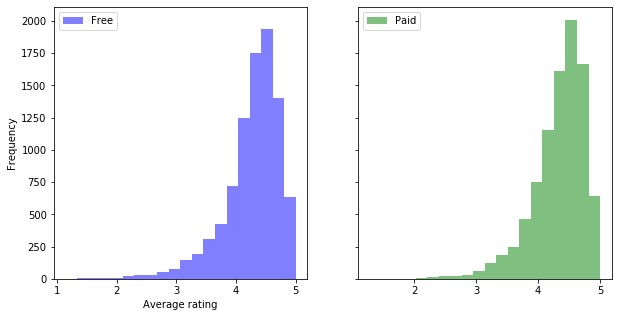

In [163]:
bins_num = 20
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, tight_layout=False)
axs[0].hist(df_free_s['Rating'],bins = bins_num, label = 'Free', alpha =0.5, color = 'blue')
axs[0].legend()
axs[1].hist(df_paid_s['Rating'],bins = bins_num, label = 'Paid',alpha = 0.5, color ='green')
axs[1].legend()
axs[0].set_xlabel('Average rating')
axs[0].set_xlabel('Average rating')
axs[0].set_ylabel('Frequency')

From the quick glance on average ranting distribution histogram we can see that distributions are not normal, but  we need to test both samples for normality, and than decide what parametric or non-parametric statistical test to run to test the proposed hypothesis. 

In [79]:
print('Testing samples for nomality using describtion of samples')
st_free = stats.describe(df_free_s['Rating'])
st_paid = stats.describe(df_paid_s['Rating'])
print(f'Free apps stats: mean: {st_free.mean}; skewness {st_free.skewness}; kurtosis {st_free.kurtosis}')
print(f'Paid apps stats: mean: {st_paid.mean}; skewness {st_paid.skewness}; kurtosis {st_paid.kurtosis}')

Testing samples for nomality using describtion of samples
Free apps stats: mean: 4.271653119594222; skewness -1.5571149774851432; kurtosis 3.9029090735530483
Paid apps stats: mean: 4.333066264175334; skewness -1.4437041692762107; kurtosis 3.483257993338495


Based of moderate skewness and high kurtosis we can conclude that both distributions are not normal, and non-parametric statistical tests should be used.  Free apps rating and paid apps rating are independent groups, and have no-normal distribution Mann-Whitney U test is the best choice for statistical analysis.

In [100]:
st_mw_test = stats.mannwhitneyu(df_free_s['Rating'],df_paid['Rating'])
print(f'Resutls of Mann-Whitney U test: \n p = {st_mw_test.pvalue}; \nstatistic: {st_mw_test.statistic}')

Resutls of Mann-Whitney U test: 
 p = 6.526505327771993e-19; 
statistic: 38084316.5 


Very small p-value obtained from Mann-Whitney statistical test indicates significant difference between samples, that is why null hypothesis should be rejected.

## Results and Conclusion 

Statistical test showed significant difference in average rating for free and paid apps, this mean users evaluates these two groups of apps differently. If we look and compare average ranking for all free and all paid apps, we can see average ranking of paid apps is 4.33, which is higher than average ranking for free apps (4.25).  Higher average rating for paid apps may indicate better quality, and users are more satisfied with paid than with free apps. 


In [138]:
#Finding statistics like standart deviation, means etc. for rating of free and paid apps;
st_descr_free = df_free_s['Rating'].describe() 
st_descr_paid = df_paid_s['Rating'].describe()

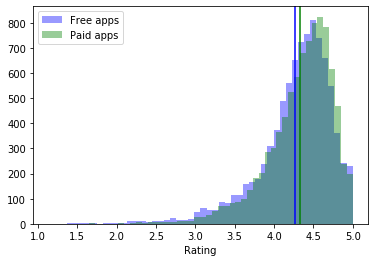

In [165]:
# Histogram of rating distribution of free and paid apps samples, vertincal lines represent average values
# each distribution
sns.distplot(df_free_s['Rating'], kde = False, label = 'Free apps', color ='blue')
sns.distplot(df_paid_s['Rating'], kde = False, label = 'Paid apps', color = 'green')
plt.legend()
plt.axvline(st_descr_free['mean'], color ='blue')
plt.axvline(st_descr_paid['mean'], color ='green')


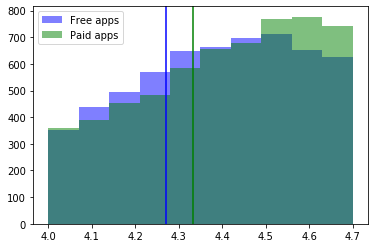

In [207]:
plt.hist(df_free_s['Rating'],label = 'Free apps', color ='blue', alpha = 0.5, range = [4,4.7])
plt.hist(df_paid_s['Rating'],  label = 'Paid apps', color = 'green',alpha = 0.5,range = [4,4.7])
plt.legend()
plt.axvline(st_descr_free['mean'], color ='blue')
plt.axvline(st_descr_paid['mean'], color ='green')

Further analysis we can find what is the most popular category for paid and free apps looking into plots below:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 <a list of 49 Text xticklabel objects>)

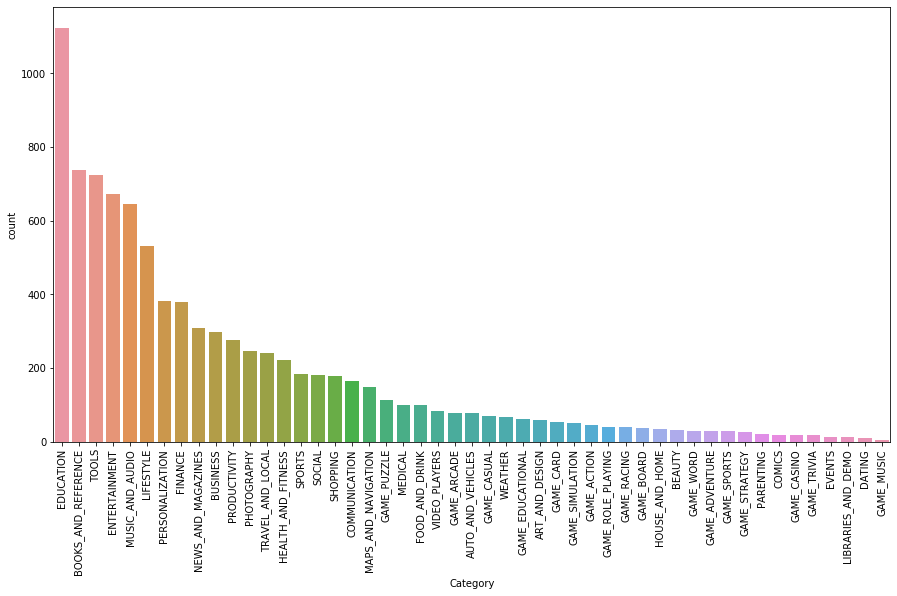

In [230]:
#Free apps categoty histogram
plt.figure(figsize=(15,8))
sns.countplot(x=df_free_s['Category'], order = df_free_s['Category'].value_counts().index)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text xticklabel objects>)

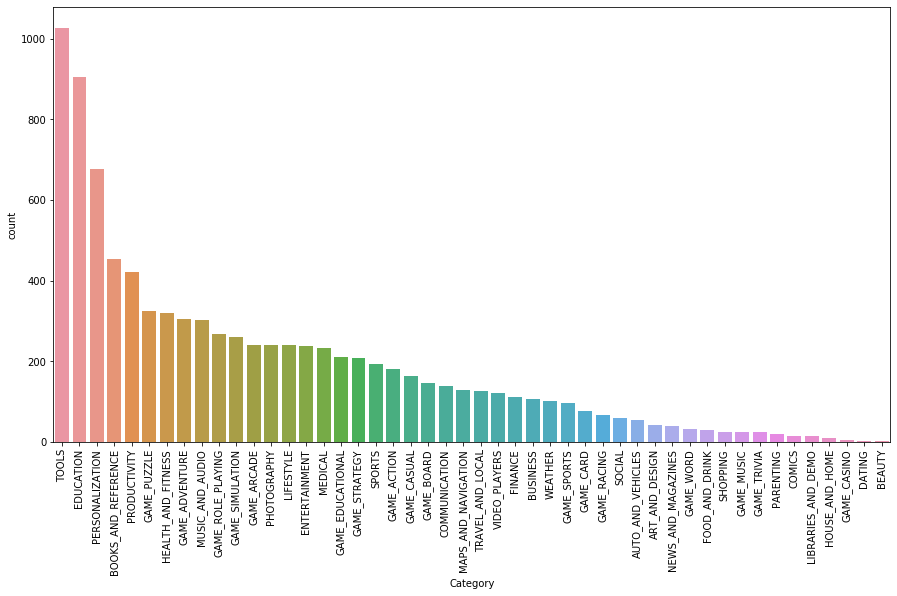

In [232]:
#Paid apps categoty histogram
plt.figure(figsize=(15,8))
sns.countplot(x=df_paid_s['Category'], order = df_paid_s['Category'].value_counts().index)
plt.xticks(rotation=90)

From histograms we can see the most free apps are in Education category and the most of paid of paid apps are in Tools category. Tools apps are made to perform specific function, and users download (buy) these apps with more clear understanding what they want to get from these tools. On the other hand Educational apps could be very diverse, as well as the quality of these apps. 